<a href="https://colab.research.google.com/github/gasparmamac/DeepLearningNotebook/blob/main/Implementing_LeNet_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Implementing LeNet in Keras

In [51]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from dataclasses import dataclass

block_plot = False

# fix seeds for reproducibility
SEED_VALUE = 29
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

<h1>1 System Cofiguratuion

In [52]:
def system_config():

  # get list of GPUs
  gpu_devices = tf.config.list_physical_devices('GPU')
  print(gpu_devices)

  if len(gpu_devices) > 0:
    print('Using GPU')
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    # if there are any gpu devices, use first gpu
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

    # enable using cudNN
    os.environ['TF_USE_CUDNN'] = 'true'
  
  else:
    print('Using CPU')

system_config()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


<h1>2 Dataset Processing

In [53]:
def get_data():

  mnist_data = tf.keras.datasets.mnist

  # load dataset
  (train_data, train_label), (test_data, test_label) = mnist_data.load_data()

  return (train_data, train_label), (test_data, test_label)

2.1 Data Preprocessing Pipeline

In [54]:
def preprocess_dataset(train_set, test_set, resize_to=None, num_classes=10, seed=3):

  (train_data, train_label) = train_set
  (test_data, test_label) = test_set

  # split training data into train and validation
  train_data, valid_data, train_label, valid_label = train_test_split(
      train_data,
      train_label,
      shuffle=True,
      test_size=0.1,
      random_state=seed,
  )

  # add axis to grayscale:
  if len(train_data.shape) !=4:
    train_data = tf.expand_dims(train_data, axis=3)
    valid_data = tf.expand_dims(valid_data, axis=3)
    test_data = tf.expand_dims(test_data, axis=3)

  # resize images if requested
  if resize_to:
    if isinstance(resize_to, int):
      resize_to = (resize_to, resize_to)
    train_data = tf.image.resize(train_data, resize_to)
    valid_data = tf.image.resize(valid_data, resize_to)
    test_data = tf.image.resize(test_data, resize_to)

  # display preprocessed dataset
  n_train = train_data.shape[0]
  n_valid = valid_data.shape[0]
  n_test = test_data.shape[0]
  image_shape = train_data.shape
  print('\n')
  print('There are {} training samples'.format(n_train))
  print('There are {} validation samples'.format(n_valid))
  print('There are {} test samples'.format(n_test))
  print('Image data shape {}'.format(image_shape))

  # comfirm number of classes present in the dataset matches the specified number of classes
  assert num_classes == len(
      np.unique(train_label)
  ), 'Number of classes present in the dataset does not match specified number of classes'

  print('There are {} classes'.format(num_classes))

  NUM_CLASSES = num_classes

  # one-hot encode labels if necessary
  if len(train_label.shape) != 2:
    train_label = tf.one_hot(train_label, NUM_CLASSES)
    valid_label = tf.one_hot(valid_label, NUM_CLASSES)
    test_label = tf.one_hot(test_label, NUM_CLASSES)

  print('\nData split:\n')
  print(f'train_data: {train_data.shape}, train_label: {train_label.shape}')
  print(f'valid_data: {valid_data.shape}, valid_label: {valid_label.shape}')
  print(f'test_data: {test_data.shape}, test_label: {test_label.shape}')

  # normalize pixel values to the range" [0. - 1.0]
  train_data = train_data / 255.0
  valid_data = valid_data / 255.0
  test_data = test_data / 255.0

  print('\nGround truth labels have been one-hot encoded:\n')
  print(np.transpose(train_label[:9]))

  return (train_data, train_label), (valid_data, valid_label), (test_data, test_label)

2.2 Data visualization

In [55]:
from string import whitespace
def visualize_samples(X, y):

  plt.figure(figsize=(18, 8))
  for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap='gray')
    plt.xlabel(y[i])
    plt.axis('off')

  plt.suptitle('Dataset samples',fontsize=18)
  plt.subplots_adjust(wspace=0.2, hspace=0.2)
  plt.show(block=block_plot)
  plt.close()

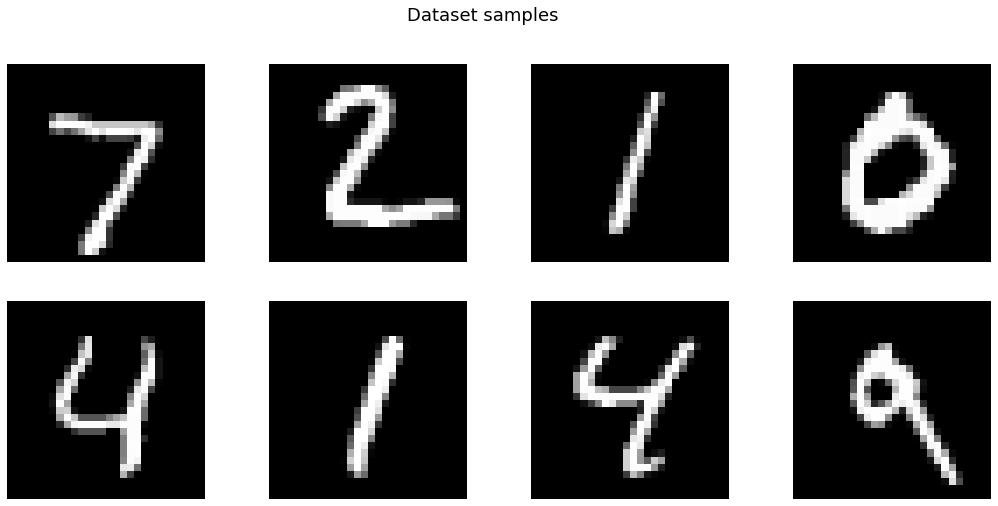

In [56]:
# download the mnist
(train_data, train_label), (test_data, test_label) = get_data()
visualize_samples(test_data, test_label)

2.3 Preprocess the Dataset

In [57]:
@dataclass(frozen=True)
class DatasetConfig:
  IMG_HEIGHT: int = 32
  IMG_WIDTH: int = 32
  IMG_CHANNELS: int = 1
  NUM_CLASSES: int = 10

@dataclass(frozen=True)
class TrainingConfig:
  BATCH_SIZE: int = 32
  EPOCHS: int = 21
  LEARNING_RATE: int = 0.01

data_config = DatasetConfig()
training_config = TrainingConfig()

# preprocess the dataset
((train_data, train_label),
 (valid_data, valid_label),
 (test_data, test_label)) = preprocess_dataset((train_data, train_label), (test_data, test_label),
                                               resize_to=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH),
                                               num_classes=data_config.NUM_CLASSES,
                                               )



There are 54000 training samples
There are 6000 validation samples
There are 10000 test samples
Image data shape (54000, 32, 32, 1)
There are 10 classes

Data split:

train_data: (54000, 32, 32, 1), train_label: (54000, 10)
valid_data: (6000, 32, 32, 1), valid_label: (6000, 10)
test_data: (10000, 32, 32, 1), test_label: (10000, 10)

Ground truth labels have been one-hot encoded:

[[0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]


<h1>3 Modeling the LeNet5 Architecture

In [58]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, Input, MaxPool2D

In [59]:
def LeNet5_model(input_shape=(32, 32, 1), num_classes=10, print_summary=True):
  
  inputs = Input(shape=input_shape)

  # BODY (feature extractor)
  x = Conv2D(6, 5, padding='valid')(inputs)                                     # input_size = (32,32), output size = (28,28)
  x = Activation('relu')(x)                                                     # output size = (28, 28)
  x = MaxPool2D()(x)                                                            # outpyt size = (14, 14)
  
  x = Conv2D(16, 5, padding='valid')(x)                                         # input size = (14,14), output size = (10,10)
  x = Activation('relu')(x)                                                     # input size = (10,10)
  feature_extractor_output = MaxPool2D()(x)                                     #output size = (5,5)

  # flatten
  flattened = Flatten()(feature_extractor_output)                               # 5*5*16 -> 400   

  # HEAD
  x = Dense(120, activation='relu')(flattened)                                  # 400 -> 120
  x = Dense(84, activation='relu')(x)                                           # 120 -> 84

  # Softmax output layer
  headout = Dense(num_classes, activation='softmax')(x)                         # 84 -> 10

  # create model
  model = Model(inputs=inputs, outputs=headout, name='LeNet5')

  if print_summary:
    model.summary()
  
  return model



<h1>4 Training Pipeline

In [60]:
def train_model(train_set, print_model_summary=False):

  (train_data, train_label) = train_set

  # initialize the leNet model
  model = LeNet5_model(input_shape=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH, data_config.IMG_CHANNELS),
                       num_classes=data_config.NUM_CLASSES,
                       print_summary=print_model_summary,
                       )
  
  # compile the model
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=training_config.LEARNING_RATE),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'],
                )
  
  print('\n\n')
  # train the model
  results = model.fit(train_data,
                      train_label,
                      epochs=training_config.EPOCHS,
                      batch_size=training_config.BATCH_SIZE,
                      validation_data=(valid_data, valid_label),
                      )
  
  return model, results

<h1>5 Training Execution

In [61]:
model, training_results = train_model(train_set=(train_data, train_label), print_model_summary=True)

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 activation_2 (Activation)   (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 activation_3 (Activation)   (None, 10, 10, 16)        0         
                                                            

5.1 Plot Training Result

In [62]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

def plot_result(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

  fig, ax = plt.subplots(figsize=(15, 4))

  if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
    metrics = [metrics, ]
    metric_name = [metric_name]

  for idx, metric in enumerate(metrics):
    ax.plot(metric, color=color[idx])

  plt.xlabel('Epoch')
  plt.ylabel('ylabel')
  plt.title(ylabel)
  plt.xlim([0, training_config.EPOCHS-1])
  plt.ylim(ylim)
  
  # tailor xaxis tick mark
  ax.xaxis.set_major_locator(MultipleLocator(5))
  ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
  ax.xaxis.set_minor_locator(MultipleLocator(1))

  plt.grid(True)
  plt.legend(metric_name)
  plt.show()
  plt.close()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


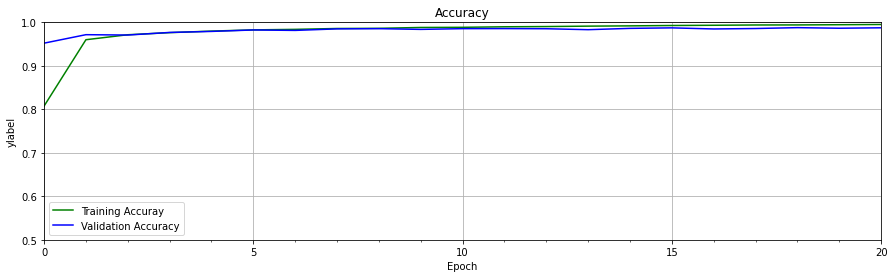

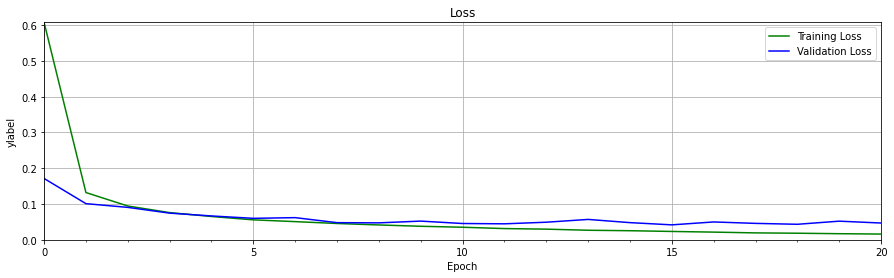

In [63]:
# print history dictionary keys
print(training_results.history.keys())

# retrieve training results
train_loss = training_results.history['loss']
train_acc = training_results.history['accuracy']
valid_loss = training_results.history['val_loss']
valid_acc = training_results.history['val_accuracy']

plot_result([train_acc, valid_acc],
            ylabel='Accuracy',
            ylim=[0.5, 1.0],
            metric_name=['Training Accuray', 'Validation Accuracy'],
            color=['g', 'b'])

max_loss = max(max(train_loss), max(valid_loss))

plot_result([train_loss, valid_loss], 
            ylabel='Loss',
            ylim=[0.0, max_loss],
            metric_name=['Training Loss', 'Validation Loss'],
            color=['g', 'b']);

<h1>6 Model Evaluation

In [66]:
def evaluate_model(model, *test_set):
  
  test_data, test_label = test_set

  # evaluate model performance on the test set
  test_result = model.evaluate(test_data, test_label)

  # select 20 random points from the test set for display
  random.seed(SEED_VALUE)
  num_rows = 4
  num_cols = 5
  num_data = num_rows*num_cols
  shuffled_index = random.sample(range(test_label.shape[0]), num_data)

  data_sampled = tf.gather(test_data, shuffled_index)
  label_sampled = tf.gather(test_label, shuffled_index)

  # generate predictions on the samples test set
  label_pred_sampled = model.predict(data_sampled)

  num_matches = 0

  # plot the test images and predicted labels
  plt.figure(figsize=(18, 12))
  for i in range(num_data):
    plt.subplot(num_rows, num_cols, i+1)
    pred = np.argmax(label_pred_sampled[i])
    truth = np.argmax(label_sampled[i])
    title = 'True: ' + str(truth) + '; Pred: ' + str(pred)
    title_obj = plt.title(title, fontdict={'fontsize': 16})

    if pred == truth:
      num_matches += 1
      plt.setp(title_obj, color='g')
    else:
      plt.setp(title_obj, color='r')
    plt.axis('off')
    plt.imshow(data_sampled[i].numpy().squeeze(), cmap ='gray')

  plt.subplots_adjust(wspace=0.2, hspace=0.2)
  plt.show(block=block_plot) 

  return test_result

1/1 [==============================] - 0s 22ms/step


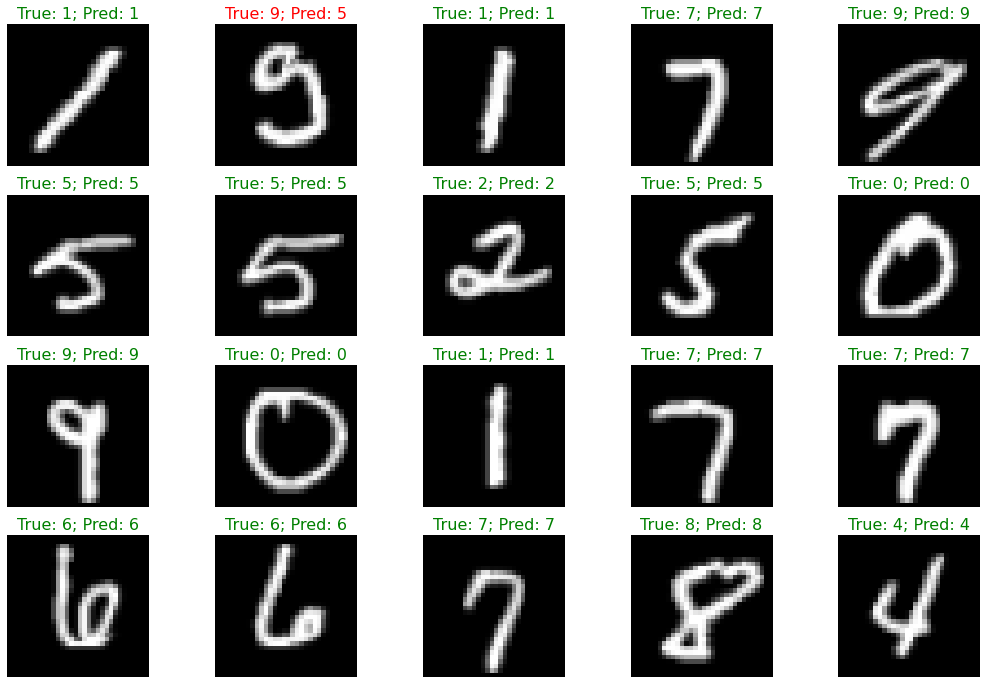

In [67]:
test_set = (test_data, test_label)
test_result = evaluate_model(model, *test_set)